# Local Businesses' Classification

### Importing essential libraries

In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA

from xgboost import XGBClassifier
import pickle

from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
%matplotlib inline
%config IPCompleter.use_jedi = False

In [2]:
### Importing revenue dataset

revenue_df = pd.read_csv("generated_revenue_data.csv")
revenue_df.head()

,Unnamed: 0,ISBN,store_name,gender_of_owner,2010_revenue_till_june,2011_revenue_till_june,2012_revenue_till_june,2013_revenue_till_june,2014_revenue_till_june,2015_revenue_till_june,2016_revenue_till_june,2017_revenue_till_june,2018_revenue_till_june,2019_revenue_till_june,2020_revenue_till_june,zip_codes
0,0,357765302-7,Waters-Wunsch,Female,100819,112509,123944,137538,149566,164316,179411,198312,218097,230448,129431,94621
1,1,998155268-2,VonRueden-Jenkins,Male,113084,126738,139531,153422,167274,186978,197318,215656,231218,248714,110034,94546
2,2,515154998-7,"Stanton, Gislason and Deckow",Female,146726,158604,177580,194941,208128,218759,230549,247263,263878,279697,173066,94116
3,3,997744982-1,Auer-Lind,Female,115260,127096,138848,149751,161231,176138,187878,198611,214950,231737,102909,94970
4,4,484474585-9,Zulauf and Sons,Female,119924,130434,141699,154061,165971,176935,190425,204749,214778,228993,123748,94558


## Data Cleaning

In [3]:
# Firtly, it is necessary to drop features that are not necessary for our analysis
# Dropping features -> Unnamed, ISBN, store_name and zip_code, that do not have any positive impact on our dataset

revenue_df.drop(["Unnamed: 0", "ISBN", "store_name", "zip_codes", "gender_of_owner"], axis=1, inplace=True)
revenue_df.head()

,2010_revenue_till_june,2011_revenue_till_june,2012_revenue_till_june,2013_revenue_till_june,2014_revenue_till_june,2015_revenue_till_june,2016_revenue_till_june,2017_revenue_till_june,2018_revenue_till_june,2019_revenue_till_june,2020_revenue_till_june
0,100819,112509,123944,137538,149566,164316,179411,198312,218097,230448,129431
1,113084,126738,139531,153422,167274,186978,197318,215656,231218,248714,110034
2,146726,158604,177580,194941,208128,218759,230549,247263,263878,279697,173066
3,115260,127096,138848,149751,161231,176138,187878,198611,214950,231737,102909
4,119924,130434,141699,154061,165971,176935,190425,204749,214778,228993,123748


In [4]:
# Since we generated the data - we dont expect to have missing values

# However, it is a good practice to check for any missing values in the dataset

# As we can see below, the dataset doesnt have any missing values

revenue_df.isnull().sum()

2010_revenue_till_june    0
2011_revenue_till_june    0
2012_revenue_till_june    0
2013_revenue_till_june    0
2014_revenue_till_june    0
2015_revenue_till_june    0
2016_revenue_till_june    0
2017_revenue_till_june    0
2018_revenue_till_june    0
2019_revenue_till_june    0
2020_revenue_till_june    0
dtype: int64

## Generating labels for the dataset

     Labels would give classes to local book stores according to the capacity they are financially hit

### Using clustering to generate labels for the stores
     
     Checking the dataset for optimal cluster size - using elbow method

In [5]:
# finding optimal cluster size depending on sum-of-squared-errors

def elbow_method(data, max_limit):
    sse=[]

    # Running clustering for sizes of 1 to 10
    K_range = range(1, max_limit+1)
    for k in K_range:
        clusters = KMeans(n_clusters=k)
        clusters = clusters.fit(data)
        sse.append(clusters.inertia_)
    print("The sum of squared errors is: ", sse)
    print()

    # Plotting for each of cluster sizes along with their sse values
    plt.plot(K_range, sse, 'bx-')
    plt.ylabel("Sum of Squared Errors")
    plt.xlabel("Number of clusters")
    plt.title("Optimization of cluster size using elbow method")
    plt.show()


The sum of squared errors is:  [30665067972866.07, 8570604830575.145, 3654199005592.038, 2315737154394.3945, 1556407756925.0225, 1184379994238.2922, 955912009870.3429, 773111152813.2471, 692290349816.5796, 620212203453.9529]



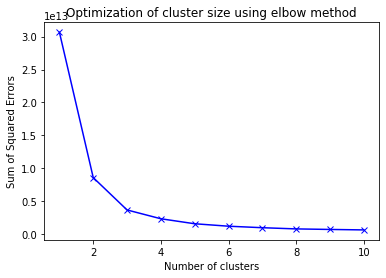

In [6]:
# Running elbow method to find out the optimum number of clusters for labelling

# As we can see below - the optimal number of clusters is three

elbow_method(revenue_df, 10)

In [19]:
# Clustering our dataset into three clusters according to elbow method

kmeans_clusters = KMeans(n_clusters=3).fit(revenue_df)

# Extracting cluster labels
cluster_labels = kmeans_clusters.labels_

# Assigning labels to data in our dataset based their indices
label_0 = list()
label_1 = list()
label_2 = list()

#clusters with their labeling
clusters = [label_0, label_1, label_2]

# Cluster labeling assignments
for group in set(cluster_labels):

    for i in revenue_df.index:
        if cluster_labels[i] == group:
            clusters[group].append(revenue_df.index[i])

In [42]:
# Adding a 'label' column to our dataset
revenue_df['labels'] = [0] * len(revenue_df)

for i in range(len(revenue_df)):
    if i in label_0:
        revenue_df['labels'][i] = 0
    elif i in label_1:
        revenue_df['labels'][i] = 1
    else:
        revenue_df['labels'][i] = 2

## Visualizing Clusters Using PCA
        Converting the multidimensional data into two dimensions suitable for visualization

In [105]:
# Utilizing PCA to convert the dataset into two dimensional dataset
pca = PCA(n_components=2, random_state=42)
revenue_pca = pca.fit_transform(revenue_df)
pca_2d = pd.DataFrame(revenue_pca)
pca_2d.shape

(1000, 2)

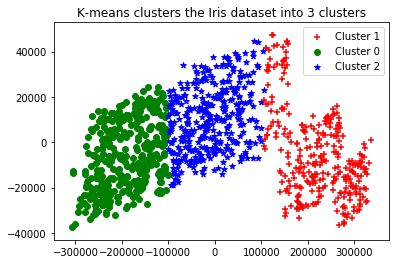

In [120]:
for i in range(0, pca_2d.shape[0]): 
    if kmeans_clusters.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[0][i],pca_2d[1][i],c='r',marker='+')
    elif kmeans_clusters.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[0][i],pca_2d[1][i],c='g',marker='o')
    elif kmeans_clusters.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[0][i],pca_2d[1][i],c='b',marker='*')
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 0',
    'Cluster 2'])
plt.title('K-means clusters the Iris dataset into 3 clusters')
plt.show()

# Building A Classification Model

In [48]:
# Storing the labels in a separate variable and dropping from the dataset for training

labels = revenue_df['labels']
revenue_df.drop('labels', axis=1, inplace=True)
revenue_df.head()

,2010_revenue_till_june,2011_revenue_till_june,2012_revenue_till_june,2013_revenue_till_june,2014_revenue_till_june,2015_revenue_till_june,2016_revenue_till_june,2017_revenue_till_june,2018_revenue_till_june,2019_revenue_till_june,2020_revenue_till_june
0,100819,112509,123944,137538,149566,164316,179411,198312,218097,230448,129431
1,113084,126738,139531,153422,167274,186978,197318,215656,231218,248714,110034
2,146726,158604,177580,194941,208128,218759,230549,247263,263878,279697,173066
3,115260,127096,138848,149751,161231,176138,187878,198611,214950,231737,102909
4,119924,130434,141699,154061,165971,176935,190425,204749,214778,228993,123748


## Splitting the dataset into training and testing subsets
        Splitting the values into 80% train and 20% testing subsets
     

In [50]:
# Splittting the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(revenue_df, labels, test_size=0.2, random_state=42, shuffle=True)

## Training Classification models
    For this classification task, we will compare SVM and Random Forest Classification Algorithms

## Support Vector Machine Classification Algorithm
    GridSearchCV is used for the purpose of cross correlation among parameters of algorithms

In [53]:
# Function to print the results for the every combination of the GridSearchCV

def print_results(results):
    print("Best Params: {}\n".format(results.best_params_))   
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,3), round(std*2, 3), params))

In [54]:
# Defining Support Vector Machine

svc = SVC()

# SVM parameters
parameters = { 'kernel': ['linear','rbf'], 'C': [0.01, 0.1]}

# Utilizing GridSearchCV for cross-correlation
cv = GridSearchCV(svc, parameters, cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1], 'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
# Accuracy of the SVM based on various parameter combinations
print_results(cv)

Best Params: {'C': 0.01, 'kernel': 'linear'}

0.995 (+/-0.005) for {'C': 0.01, 'kernel': 'linear'}
0.971 (+/-0.027) for {'C': 0.01, 'kernel': 'rbf'}
0.995 (+/-0.005) for {'C': 0.1, 'kernel': 'linear'}
0.992 (+/-0.009) for {'C': 0.1, 'kernel': 'rbf'}


In [57]:
# Running predictions based on the SVM model
test_pred = cv.predict(X_test)

In [58]:
# Accuracy of the model for testing dataset
# As we can see below, the model has 99.5% accuracy on classification
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))

Accuracy score for Testing Dataset =  0.995


# Ensemble Classifiers

In [69]:
# Utilizting voting classification using ensemble methods
ensemble_voting = VotingClassifier([ 
    ('et', OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 1000))),
    ('randomforest', RandomForestClassifier(n_estimators=1000)),
    ('ada', AdaBoostClassifier(learning_rate=0.1, n_estimators=1000)),
    ('xgboost', XGBClassifier(learning_rate =0.1, n_estimators=1000, num_class = 3))],  voting='soft', weights=[1,2,1,1])

In [70]:
# fitting the training dataset to the algorithms
# Algorithms are provided with parameters and weights 
ensemble_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('et',
                              OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False,
                                                                                 ccp_alpha=0.0,
                                                                                 class_weight=None,
                                                                                 criterion='gini',
                                                                                 max_depth=None,
                                                                                 max_features='auto',
                                                                                 max_leaf_nodes=None,
                                                                                 max_samples=None,
                                                                                 min_impurity_decrease=0.0,
                                                               

In [71]:
# Prediction of results on the test dataset
test_pred = ensemble_voting.predict(X_test)

In [73]:
# Accuracy for the testing dataset
# As shown below, the accuracy is 99.5% 
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))

Accuracy score for Testing Dataset =  0.995


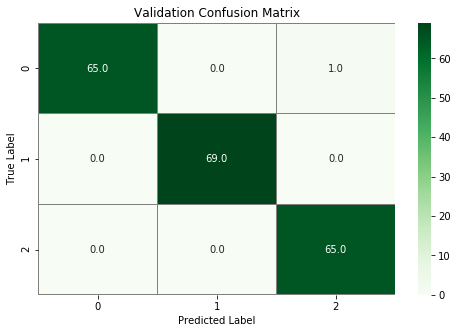

In [74]:
# Both SVM and Ensemble methods performed with same classification accuracy

# Due to the robust nature of Ensemble methods, we are using classification results 

# computing the confusion matrix for ensemble methods classification results
confusion_mtx = confusion_matrix(y_test, test_pred) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

In [77]:
# Classification report for emsemble methods
print(classification_report(test_pred, y_test))

precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       1.00      1.00      1.00        69
           2       1.00      0.98      0.99        66

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [123]:
# Exporting and saving the classification model to disk

with open('local_store_classifier.pkl', 'wb') as file:
    pickle.dump(ensemble_voting, file)